# Quantum phase estimation

In this tutorial, we will look at various methods for estimating eigenenergies $E_j$ of a Hamiltonian $H$, or equivalently (for sufficiently small $t$), eigenphases $\phi_j=-E_jt$ of a unitary operator $U=e^{-iHt}$. 

1. Multi-ancilla QPE
    1. Controlled unitary circuits
    1. Unitaries on multiple ancillas
    1. The quantum Fourier transform
1. Single-ancilla QPE
    1. Robust phase estimation
    1. Prony estimation
    1. Scaling

# Multi-ancilla QPE
Let us take a very simple Hamiltonian to begin:
$$ H = H_0 ZI + H_1 IZ + H_2 ZZ $$

Though not particularly interesting, this Hamiltonian has the advantage of being easy to solve and characterize

**Problem 1:** Write down the eigenvalues and corresponding eigenvectors of $H$ in terms of the three parameters $H_0$, $H_1$, and $H_2$. What are the equivalent eigenvalues and eigenvectors of $U$?

In [1]:
def get_eigenvalues(H0, H1, H2):
    return [H0+H1+H2, H0-H1-H2, -H0+H1-H2, -H0-H1+H2]

## Controlled unitary circuits
Quantum phase estimation requires that we perform $U=e^{-iHt}$ conditional on an ancilla qubit. That is, that we apply the unitary
$$ I\oplus U = \left(\begin{array}{cc}1 & 0 \\ 0 & U\end{array}\right) $$
Let's first try implementing $U$ by itself. Recall from previous lectures that we can apply $U$ via Trotterization --- separately applying $e^{-iH_0ZIt}$, $e^{-iH_1IZt}$, and $e^{-iH_2ZZt}$.

**Problem 2:** Write circuits to implement the above three unitary operations using rz rotations and CNOT gates

In [2]:
import cirq

qubits = [cirq.GridQubit(0,0), cirq.GridQubit(0,1)]

def time_evolution_H0(H0, t):
    # Note the factor of -2, as cirq.rz(theta) implements exp(-i*Z*theta/2).
    yield cirq.rz(2*H0*t).on(qubits[0])
    
def time_evolution_H1(H1, t):
    yield cirq.rz(2*H1*t).on(qubits[1])
    
def time_evolution_H2(H2, t):
    yield cirq.CNOT(qubits[0], qubits[1])
    yield cirq.rz(2*H2*t).on(qubits[1])
    yield cirq.CNOT(qubits[0], qubits[1])

# Plug in some values for our parameters    
H0 = 0.7
H1 = 1.2
H2 = 0.8
t = 0.5
circuit = cirq.Circuit([time_evolution_H0(H0, t),
                        time_evolution_H1(H1, t),
                        time_evolution_H2(H2, t)])
print(circuit)


(0, 0): ───Rz(0.223π)───@────────────────@───
                        │                │
(0, 1): ───Rz(0.382π)───X───Rz(0.255π)───X───


**Problem 3:** Use cirq.unitary to check the values of the generated unitary against your answers to problem 1.

In [3]:
import numpy as np
unitary = cirq.unitary(circuit)
print(np.round([np.angle(unitary[j,j]) / -t for j in range(4)], 2))
print(np.round(get_eigenvalues(H0, H1, H2), 2))

[ 2.7 -1.3 -0.3 -1.1]
[ 2.7 -1.3 -0.3 -1.1]


The simplest method to implement a circuit controlled by an ancilla qubit is simply to control each and every one of the gates. However, this is relatively high-cost, as we must then decompose three-qubit gates in terms of two-qubit gates.

A more economical method is to realize that, in the above circuit, chains of CNOT gates will cancel out if the Z-rotation gate between them is not implemented. This implies that we need only control the Z gates on the above qubits for QPE (a much more practical implementation).

One technical point of the above - the native gate in superconducting qubit hardware is the controlled-phase gate cirq.CZ**\phi (with a diagonal $(1,1,1,e^{i\phi*\pi})$), and not the controlled-rz gate (with a diagonal $(1,1,e^{-i\phi},e^{i\phi})$). We need to make sure we translate between these so as to not pick up spurious phases.

**Problem 4:** Write a function that implements controlled-rz in terms of the cirq.CZ gate and cirq.rz gates

In [4]:
def crz(control, target, phase):
    yield cirq.CZ(target, control)**(2*phase/np.pi)
    yield cirq.rz(-phase).on(control)
    
test_unitary = cirq.unitary(cirq.Circuit(crz(qubits[0],qubits[1],np.pi/2)))
print((test_unitary / test_unitary[0,0]).round(2))

[[1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 1.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.-1.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+1.j]]


Now, let's use this to make our circuit controlled

**Problem 5:** Implement a controlled version of the above circuits.

In [5]:
ancilla = cirq.GridQubit(1,0)

def controlled_time_evolution_H0(ancilla, H0, t):
    # Check factors of 2 here again!
    yield crz(ancilla, qubits[0], H0*t)
    
def controlled_time_evolution_H1(ancilla, H1, t):
    yield crz(ancilla, qubits[1], H1*t)
    
def controlled_time_evolution_H2(ancilla, H2, t):
    yield cirq.CNOT(qubits[0], qubits[1])
    yield crz(ancilla, qubits[1], H2*t)
    yield cirq.CNOT(qubits[0], qubits[1])
    
circuit = cirq.Circuit([controlled_time_evolution_H0(ancilla, H0, t),
                        controlled_time_evolution_H1(ancilla, H1, t),
                        controlled_time_evolution_H2(ancilla, H2, t)])
print(circuit)

# Check angles again
unitary = cirq.unitary(circuit)
print()
print(np.round([np.angle(unitary[j,j]/unitary[0,0]) / -t for j in range(8)], 2))
print(np.round(get_eigenvalues(H0, H1, H2), 2))

(0, 0): ───@─────────────────────────────────@───────────────────────@─────────────
           │                                 │                       │
(0, 1): ───┼───────────────────────@─────────X─────────────@─────────X─────────────
           │                       │                       │
(1, 0): ───@^(2/9)───Rz(-0.111π)───@^0.382───Rz(-0.191π)───@^0.255───Rz(-0.127π)───

[-0.   2.7 -0.  -1.3 -0.  -0.3 -0.  -1.1]
[ 2.7 -1.3 -0.3 -1.1]


## Multiple-ancilla evolution

Traditionally QPE is achieved by using a register of $L\sim\log(1/\epsilon)$ ancilla qubits labeled by an index $l=0,\ldots,L-1$, and performing controlled-$e^{i2^lHt}$ with each ancilla.

Luckily for us, the above code is written so as to make the extension quite easy.

**Problem 6:** write a function using the above code to implement controlled $e^{i2^lHt}$ for a register of $l=0,\ldots,L-1$ ancilla qubits.

In [6]:
L=2
ancillas = [cirq.GridQubit(1,l) for l in range(L)]

def controlled_time_evolution_multi_ancilla(ancillas, H0, H1, H2, t):
    for l, ancilla in enumerate(ancillas):
        ### insert your code here!
        yield controlled_time_evolution_H0(ancilla, H0, (2**l)*t)
        yield controlled_time_evolution_H1(ancilla, H1, (2**l)*t)
        yield controlled_time_evolution_H2(ancilla, H2, (2**l)*t)
        
circuit = cirq.Circuit(controlled_time_evolution_multi_ancilla(ancillas, H0, H1, H2, t))
print(circuit)

(0, 0): ───@─────────────────────────────────@───────────────────────@─────────────@─────────────────────────────────@───────────────────────@─────────────
           │                                 │                       │             │                                 │                       │
(0, 1): ───┼───────────────────────@─────────X─────────────@─────────X─────────────┼───────────────────────@─────────X─────────────@─────────X─────────────
           │                       │                       │                       │                       │                       │
(1, 0): ───@^(2/9)───Rz(-0.111π)───@^0.382───Rz(-0.191π)───@^0.255───Rz(-0.127π)───┼───────────────────────┼───────────────────────┼───────────────────────
                                                                                   │                       │                       │
(1, 1): ───────────────────────────────────────────────────────────────────────────@^0.446───Rz(-0.223π)───@^0.764───Rz(-0.

Note here that for ease of checking the code / reading the result you might have and implemented $e^{i2^lHt}$ in a single shot. This is known as fast-forwarding, and for a general Hamiltonian is known to not be possible --- to implement $e^{i2^lHt}$ with constant error in both $l$ and $t$ will typically take time $2^lt$.

## The quantum Fourier transform

Traditionally to process QPE data, we would perform the inverse quantum Fourier transform on the ancilla qubits, and then read them out in the computational basis. To do this, we need to implement the quantum Fourier transform.

**Problem 7:** Write a function to implement the quantum Fourier transform on a register of qubits

In [7]:
def iqft(register):
    this_target = register[0]
    if len(register[1:]) >= 1:
        yield iqft(register[1:])
    for coefficient, this_control in enumerate(register[1:]):
        yield cirq.CZ(this_target, this_control)**(-0.5/2**coefficient)
    yield cirq.H(this_target)
        
L=5
ancillas = [cirq.GridQubit(1,l) for l in range(L)]
circuit = cirq.Circuit(iqft(ancillas))
print(circuit)

(1, 0): ─────────────────────────────────────────────────────────────────────────────@────────@─────────@──────────@───────────H───
                                                                                     │        │         │          │
(1, 1): ───────────────────────────────────────────@────────@─────────@──────────H───@^-0.5───┼─────────┼──────────┼───────────────
                                                   │        │         │                       │         │          │
(1, 2): ────────────────────@────────@─────────H───@^-0.5───┼─────────┼───────────────────────@^-0.25───┼──────────┼───────────────
                            │        │                      │         │                                 │          │
(1, 3): ───────@────────H───@^-0.5───┼──────────────────────@^-0.25───┼─────────────────────────────────@^(-1/8)───┼───────────────
               │                     │                                │                                            │
(1, 

Before we put everything together, we need to prepare the ancilla and system states.

The easiest ancilla state preparation is to prepare $\frac{1}{\sqrt{2}^L}\sum_l|l\rangle$.

For the system preparation, we have the freedom to prepare whatever we want - let's prepare a superposition of the $|01\rangle$ and $|10\rangle$ states.

**Problem 7:** Write a circuit to prepare the above states

In [8]:
def state_preparation_ancilla(register):
    for qubit in register:
        yield cirq.H(qubit)
        
def state_preparation_system():
    yield cirq.H(qubits[0])
    yield cirq.CNOT(qubits[0], qubits[1])
    yield cirq.X(qubits[0])

circuit = cirq.Circuit(state_preparation_system())
print(circuit)
print()
    
circuit = cirq.Circuit(state_preparation_ancilla(ancillas))
print(circuit)

(0, 0): ───H───@───X───
               │
(0, 1): ───────X───────

(1, 0): ───H───

(1, 1): ───H───

(1, 2): ───H───

(1, 3): ───H───

(1, 4): ───H───


Before we go any further, let's check that our QFT returns the right result on the prepared state (when no phase is accumulated). If the following does not return only 0, we have made a mistake!

In [9]:
circuit = cirq.Circuit(state_preparation_ancilla(ancillas))
circuit.append(iqft(ancillas))
circuit.append(cirq.measure(*ancillas, key='phase'))
simulator = cirq.Simulator()
results = simulator.run(circuit, repetitions = 1000)
print(results.histogram(key='phase'))

Counter({0: 1000})


Now let's put it all together!

**Problem 8:** combine the above code and simulate quantum phase estimation.

In [10]:
L=5
H0 = 0.125 * 2 * np.pi
H1 = 0.4 * 2 * np.pi
H2 = 0.3 * 2 * np.pi
ancillas = [cirq.GridQubit(1,l) for l in range(L)] 

### Insert your code here
circuit = cirq.Circuit()
circuit.append(state_preparation_ancilla(ancillas))
circuit.append(state_preparation_system())
circuit.append(controlled_time_evolution_multi_ancilla(ancillas, H0, H1, H2, 1))
circuit.append(iqft(ancillas))
circuit.append(cirq.measure(*ancillas, key='phase'))

simulator = cirq.Simulator()
result = simulator.run(circuit, repetitions=10000)
hist = result.histogram(key='phase')

Now, let's plot the result!

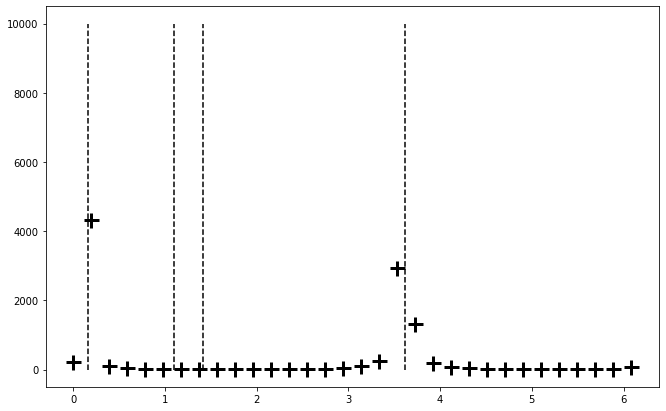

In [11]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.figure(figsize=(11,7))
histx = [x / 2**L * 2 * np.pi for x in hist]
histy = [hist[x] for x in hist]
plt.plot(histx, histy, 'k+', markersize=15,markeredgewidth=3)
plt.vlines([-x % (2 * np.pi) for x in get_eigenvalues(H0,H1,H2)],0, 10000, linestyle='dashed')

# Single-ancilla QPE

Though the above performs quite well, the use of multiple ancilla qubits adds extra overhead we can do away with. In effect, we have no need to perform the quantum Fourier transform - if we can extract the phase data accumulated on a single ancilla qubit, we can convert this into a signal classically.

To see this, let's go back to the single-ancilla phase estimation circuit, and investigate the phase accumulated between the two states of the ancilla when our system is in an eigenstate - this can be found as the expectation value of $X-iY$.

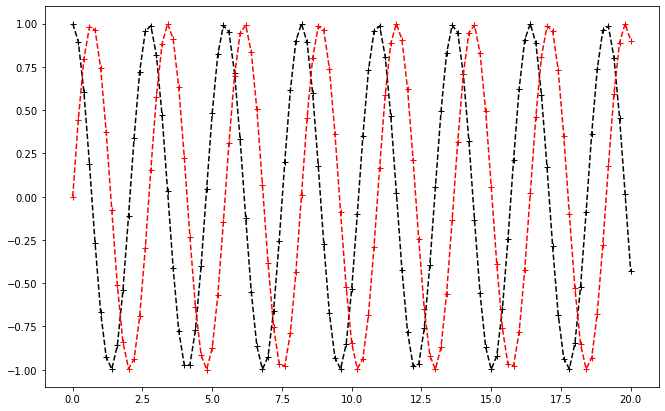

In [12]:
H0 = 1
H1 = 0.5
H2 = 0.8

M = np.kron(np.array([[0, 0], [2, 0]]),np.identity(4))


phase_values = []
time_values = np.linspace(0, 20, 101)
for t in time_values:
    circuit = cirq.Circuit([cirq.H(ancilla),
                            controlled_time_evolution_H0(ancilla, H0, t),
                            controlled_time_evolution_H1(ancilla, H1, t),
                            controlled_time_evolution_H2(ancilla, H2, t)])
    
    #simulator.simulate extracts the wavefunction at the end of the circuit
    result = simulator.simulate(circuit, qubit_order = [ancilla, *qubits])
    phase_values.append(result.final_state.conj().T @ M @ result.final_state)

plt.figure(figsize=(11,7))
plt.plot(time_values, np.real(phase_values), 'k+')
plt.plot(time_values, np.imag(phase_values), 'r+')
plt.plot(time_values, np.cos(time_values*(H0+H1+H2)), 'k--')
plt.plot(time_values, np.sin(time_values*(H0+H1+H2)), 'r--')

Next, we need a piece of code that estimates $\langle X-iY\rangle$. However, this is not a Hermitian operator, so we need to write $\langle X-iY\rangle = \langle X\rangle - i\langle Y\rangle$, and estimate these quantities separately via partial state tomography.

**Problem 9:** Write code to estimate $\langle X\rangle$ and $\langle Y\rangle$ using two separate circuits.

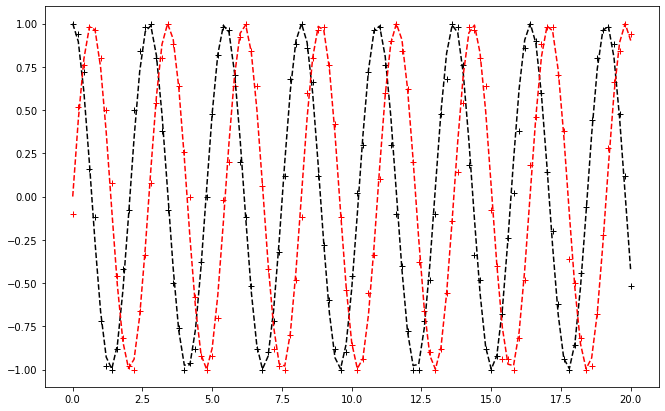

In [18]:
def state_preparation():
    return []

def get_expectation_X(state_preparation, H0, H1, H2, t, num_repetitions):
    def X_circuit():
        yield state_preparation()
        yield cirq.H(ancilla)
        yield controlled_time_evolution_H0(ancilla, H0, t)
        yield controlled_time_evolution_H1(ancilla, H1, t)
        yield controlled_time_evolution_H2(ancilla, H2, t)
        yield cirq.H(ancilla)
        yield cirq.measure(ancilla, key='res')
    circuit = cirq.Circuit(X_circuit())   
    result = simulator.run(circuit, repetitions=num_repetitions)
    return (result.histogram(key='res')[0] - result.histogram(key='res')[1]) / num_repetitions
    
def get_expectation_Y(state_preparation, H0, H1, H2, t, num_repetitions):
    def Y_circuit():
        yield state_preparation()
        yield cirq.H(ancilla)
        yield controlled_time_evolution_H0(ancilla, H0, t)
        yield controlled_time_evolution_H1(ancilla, H1, t)
        yield controlled_time_evolution_H2(ancilla, H2, t)
        yield cirq.S(ancilla)
        yield cirq.H(ancilla)
        yield cirq.measure(ancilla, key='res')
    circuit = cirq.Circuit(Y_circuit())   
    result = simulator.run(circuit, repetitions=num_repetitions)
    return (result.histogram(key='res')[1] - result.histogram(key='res')[0]) / num_repetitions

num_repetitions = 100
new_phase_values = [get_expectation_X(state_preparation, H0, H1, H2, t, num_repetitions) -
                    1j * get_expectation_Y(state_preparation, H0, H1, H2, t, num_repetitions)
                    for t in time_values]

plt.figure(figsize=(11,7))
plt.plot(time_values, np.real(new_phase_values), 'k+')
plt.plot(time_values, np.imag(new_phase_values), 'r+')
plt.plot(time_values, np.cos(time_values*(H0+H1+H2)), 'k--')
plt.plot(time_values, np.sin(time_values*(H0+H1+H2)), 'r--')

## Robust phase estimation

If you look closely, you can see some deviations between the expected signal and the obtained points. This is sampling noise --- it's proportional to the square root of the number of repetitions made. This noise will propagate through to our estimation of the phase.

As we started in an eigenstate, our signal is just a single wave - this means we can estimate the phase from a single point!

**Problem 10:** Write a function to estimate the phase from a single point of the signal.

In [21]:
def phase_estimation_single_point(time, signal):
    return np.angle(signal) / time

print("Estimating phase from point at time {}".format(time_values[1]))
print("Estimated phase = {}".format(phase_estimation_single_point(time_values[1], new_phase_values[1])))
print("True phase = {}".format(H0+H1+H2))

Estimating phase from point at time 0.2
Estimated phase = 2.526450940496973
True phase = 2.3


Probably you're seeing quite a large error here. This is because with only 100 repetitions, our estimate of the signal has an error on the order of $\sqrt{1/100}=0.1$, and this error is divided by the value of the time that we estimated at --- so the standard error of the estimate is on the order of $0.5$.

Let's investigate what happens when we tune the knobs of the number of measurements and the time-step that we estimate at:

**Problem 11:** Repeat the above procedure for different values of the number of repetitions and of the time. Plot the error in the estimation for both on a log-log scale.

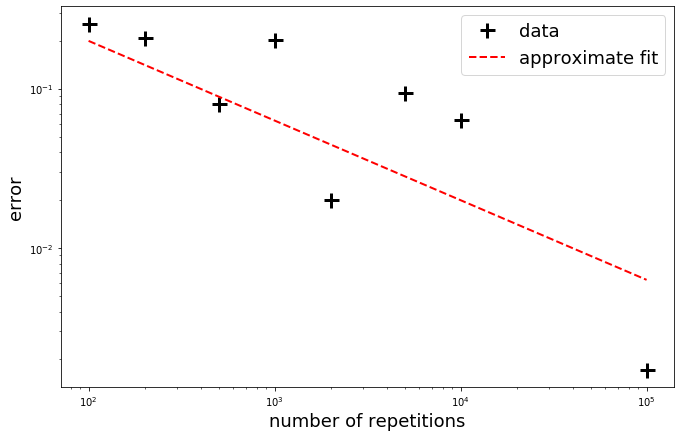

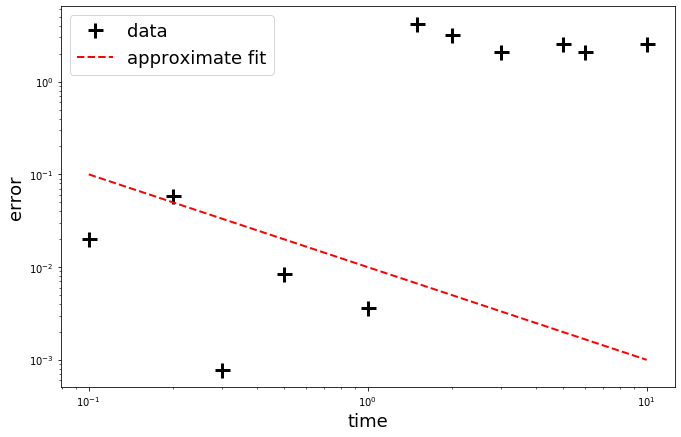

In [31]:
num_repetitions_range = [100, 200, 500, 1000, 2000, 5000, 10000, 100000]
error_increasing_repetitions = []
true_phase = H0+H1+H2
t = 0.2
for num_repetitions in num_repetitions_range:
    new_phase_value = (get_expectation_X(state_preparation, H0, H1, H2, t, num_repetitions) -
                    1j * get_expectation_Y(state_preparation, H0, H1, H2, t, num_repetitions))
    new_estimate = phase_estimation_single_point(t, new_phase_value)
    error_increasing_repetitions.append(np.abs(new_estimate - true_phase))

num_repetitions = 10000
time_range = [0.1, 0.2, 0.3, 0.5, 1, 1.5, 2, 3, 5, 6, 10]
error_increasing_time = []
for t in time_range:
    new_phase_value = (get_expectation_X(state_preparation, H0, H1, H2, t, num_repetitions) -
                    1j * get_expectation_Y(state_preparation, H0, H1, H2, t, num_repetitions))
    new_estimate = phase_estimation_single_point(t, new_phase_value)
    error_increasing_time.append(np.abs(new_estimate - true_phase))
    
plt.figure(figsize=(11,7))
plt.plot(num_repetitions_range, error_increasing_repetitions, 'k+', markersize=15, markeredgewidth=3, label='data')
plt.plot(num_repetitions_range, np.array(num_repetitions_range)**(-1/2)*2, 'r--', linewidth=2, label='approximate fit')
plt.xlabel('number of repetitions', fontsize=18)
plt.ylabel('error', fontsize=18)
plt.xscale('log')
plt.yscale('log')
plt.legend(fontsize=18)

plt.figure(figsize=(11,7))
plt.plot(time_range, error_increasing_time, 'k+', markersize=15, markeredgewidth=3, label='data')
plt.plot(time_range, np.array(time_range)**(-1)*0.01, 'r--', linewidth=2, label='approximate fit')
plt.xlabel('time', fontsize=18)
plt.ylabel('error', fontsize=18)
plt.xscale('log')
plt.yscale('log')
plt.legend(fontsize=18)


## Extra exercises

I've thrown in some guide lines for the eye (to confirm this you should repeat the calculation of each point many times and average the error). Hopefully you see that the scaling with the number of repetitions works as expected... But there is a horrible jump in the scaling with the time!

What is going on here?

The answer is that our estimate of $E_jt$ is only accurate modulo $2\pi$ - whenever $E_jt>2\pi$, we don't see that $e^{iE_jt}$ is wrapped around the complex unit circle. This places a limit on the value of $t$ we can use for this estimation. This is a bit of a shame, as our scaling with $t$ is twice as good as our scaling with the number of repetitions.

There are many methods to circumvent this issue. The basic idea is to use a small value of $t$ to form a rough estimate of $E_jt$, then use this to keep track of the modulo $2\pi$ as $t$ grows larger and larger. In this tutorial, we will use the method known as 'robust phase estimation'.

Robust phase estimation requires that we perform separate estimates $\tilde{F_j}^{(l)}$ of $E_jt\mod 2\pi$ for $t=2^lt_0$ for $l=0,\ldots,L$. Then, at each order $j>0$, we estimate $\tilde{E_j}^{(l)}$ as the number closest to $\tilde{E_j}^{(l-1)}$ such that 

$$\tilde{E_j}^{(l)}\mod (2\pi / 2^lt_0) = \tilde{F_j}^{(l)}.$$
Let's try this!

**Problem 12:** Write a function to generate a set of estimators $\tilde{F_j}^{(l)}$ from a set of input experiments.

**Problem 13:** Write an estimator for $\tilde{E_j}^{(l)}$ using the above set of estimators $\tilde{F_j}^{(l)}$. Test the scaling you obtain!

In [ ]:
def phase_estimator_modulo_2pi(exponentially_sparse_signal, t0):
    ### Insert your code here
   
def robust_phase_estimation(exponentially_sparse_signal, t0):
    ### Insert your code here

num_repetitions = 10000
t0 = 0.5
J = 10
time_range = [t0 * 2**j for j in range(0, J+1)]
exponentially_sparse_signal = [get_expectation_X(state_preparation, H0, H1, H2, t, num_repetitions) -
                                1j * get_expectation_Y(state_preparation, H0, H1, H2, t, num_repetitions)
                               for t in time_range]

error_increasing_time = robust_phase_estimation(exponentially_sparse_signal, t0)

plt.figure(figsize=(11,7))
plt.plot(time_range, error_increasing_time, 'k+', markersize=15, markeredgewidth=3, label='data')
plt.plot(time_range, np.array(time_range)**(-1)*0.01, 'r--', linewidth=2, label='approximate fit')
plt.xlabel('time', fontsize=18)
plt.ylabel('error', fontsize=18)
plt.xscale('log')
plt.yscale('log')
plt.legend(fontsize=18)

It turns out that, as stated, the above method is not completely optimal in time complexity. We need to be careful to choose the number of repetitions at later values of $j$ to be low enough that we don't completely swamp the total number of $e^{iHt}$. But this is probably beyond what we have time for in this tutorial.

## Prony phase estimation

QPE signal processing gets more complicated when we use an initial state that is not an eigenstate of our system:

In [ ]:
num_repetitions = 1000
time_values = np.linspace(0, 100, 101)
new_phase_values = [get_expectation_X(state_preparation_system, H0, H1, H2, t, num_repetitions) -
                    1j * get_expectation_Y(state_preparation_system, H0, H1, H2, t, num_repetitions)
                    for t in time_values]

plt.figure(figsize=(11,7))
plt.plot(time_values, np.real(new_phase_values), 'k+-')
plt.plot(time_values, np.imag(new_phase_values), 'r+-')

What is going on here? We have two frequencies superimposed, like two notes of a chord. Robust phase estimation will fail here, as the estimators $\tilde{F_j}^{(l)}$ explicitly assume that the input signal is a single frequency.

One way to extract multiple frequencies from this wave is via Prony's method, which can be found in the openfermion package.

In [ ]:
from openfermion import prony
amplitudes, phases = prony(new_phase_values)
plt.figure(figsize=(11,7))

plt.plot(np.angle(phases) % (2*np.pi), np.abs(amplitudes), 'k+', markersize=15, markeredgewidth=2)
plt.vlines([x % (2 * np.pi) for x in get_eigenvalues(H0,H1,H2)],0, 1, linestyle='dashed')

This is not the only way of estimating single frequencies from a more complicated signal; applying these methods to quantum phase estimation is very much a work in progress.

But, to finish this tutorial see if you can do better than yours truly at using Prony's method to estimate eigenvalues of a Hamiltonian.

**Problem 14:** Investigate the scaling of Prony's method with the number of repetitions and maximum value of $t$. How well can you do?